In [12]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import Caltech101
from torchvision.models import resnet50
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm


In [5]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# Define the path to the dataset
data_dir = 'caltech-101\caltech-101\ObjectCategories\ObjectCategories'  # Replace with your path

# Define the necessary transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset with ImageFolder
dataset = ImageFolder(root=data_dir, transform=transform)

# Check the class-to-label mapping
print("Class-to-Index Mapping:", dataset.class_to_idx)

Class-to-Index Mapping: {'BACKGROUND_Google': 0, 'Faces': 1, 'Faces_easy': 2, 'Leopards': 3, 'Motorbikes': 4, 'accordion': 5, 'airplanes': 6, 'anchor': 7, 'ant': 8, 'barrel': 9, 'bass': 10, 'beaver': 11, 'binocular': 12, 'bonsai': 13, 'brain': 14, 'brontosaurus': 15, 'buddha': 16, 'butterfly': 17, 'camera': 18, 'cannon': 19, 'car_side': 20, 'ceiling_fan': 21, 'cellphone': 22, 'chair': 23, 'chandelier': 24, 'cougar_body': 25, 'cougar_face': 26, 'crab': 27, 'crayfish': 28, 'crocodile': 29, 'crocodile_head': 30, 'cup': 31, 'dalmatian': 32, 'dollar_bill': 33, 'dolphin': 34, 'dragonfly': 35, 'electric_guitar': 36, 'elephant': 37, 'emu': 38, 'euphonium': 39, 'ewer': 40, 'ferry': 41, 'flamingo': 42, 'flamingo_head': 43, 'garfield': 44, 'gerenuk': 45, 'gramophone': 46, 'grand_piano': 47, 'hawksbill': 48, 'headphone': 49, 'hedgehog': 50, 'helicopter': 51, 'ibis': 52, 'inline_skate': 53, 'joshua_tree': 54, 'kangaroo': 55, 'ketch': 56, 'lamp': 57, 'laptop': 58, 'llama': 59, 'lobster': 60, 'lotus'

In [6]:
# Define the split sizes
train_size = int(0.67 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Check the lengths of the resulting datasets
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of training images: 6126
Number of test images: 3018


In [7]:
# Set batch size
batch_size = 32  # You can adjust this based on your memory and performance requirements

# Create data loaders for the training and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


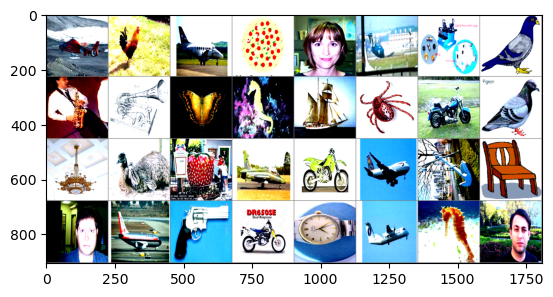

Labels: tensor([51, 78,  6, 73,  2,  6,  0, 72, 79, 46, 17, 83, 80, 92,  4, 72, 24, 38,
        90,  6,  4,  6,  7, 23,  1,  6, 76,  4, 95,  6, 83,  1])


In [9]:
# Inspect a batch of data
import matplotlib.pyplot as plt
import torchvision

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Visualize the images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Show images in the first batch
imshow(torchvision.utils.make_grid(images))
print("Labels:", labels)

In [13]:
# Load the ResNet50 model
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the final layer for embeddings
model.eval()  # Set the model to evaluation mode

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


c:\Users\ASUS\miniconda3\envs\neural_networks\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\neural_networks\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [14]:
# Function to get embeddings
def get_embeddings(dataset, model):
    embeddings = []
    labels = []
    for img, label in tqdm(dataset):
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model(img).squeeze().cpu().numpy()
        embeddings.append(embedding)
        labels.append(label)
    return np.array(embeddings), np.array(labels)

# Get embeddings for both train and test sets
train_embeddings, train_labels = get_embeddings(train_dataset, model)
test_embeddings, test_labels = get_embeddings(test_dataset, model)


100%|██████████| 3018/3018 [00:43<00:00, 70.11it/s]


In [15]:
# Define and train k-NN classifier
k = 5  # Set your preferred value for k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_embeddings, train_labels)

# Predict on the test set
test_predictions = knn.predict(test_embeddings)


In [16]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")


Test Set Accuracy: 88.87%
